In [1]:
pwd

'/home/anthonypark6904/simclr_module/utils'

In [2]:
from dataloader import mel_dataset
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

In [3]:
data = mel_dataset('/home/anthonypark6904/dev_dataset', 'total')

Load song_meta.json...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 707989/707989 [00:00<00:00, 770117.40it/s]


Load complete!

Load file list...


5it [00:00, 50.79it/s]


In [4]:
def collate_batch(batch):
    x_train = [x for x, _ in batch]
    y_train = [y for _, y in batch]                  
        
    return np.array(x_train), np.array(y_train)

In [5]:
train_dataloader = DataLoader(data, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_batch)


In [116]:
data[0][0].shape

(48, 1876)

In [117]:
a = next(iter(train_dataloader))[0]

In [118]:
a = jnp.expand_dims(a, axis=-1)

In [119]:
rng = jax.random.PRNGKey(23)

In [120]:
try:
    import dm_pix
except ModuleNotFoundError: # Install pix if missing
    !pip install --quiet dm_pix
    import dm_pix

In [121]:
a = a/130 + 1

In [122]:
img_jt = jax.lax.clamp(0.0, a[1], 1.0)


In [123]:
img_jt

DeviceArray([[[1.        ],
              [1.        ],
              [1.        ],
              ...,
              [1.        ],
              [1.        ],
              [1.        ]],

             [[1.        ],
              [1.        ],
              [1.        ],
              ...,
              [1.        ],
              [1.        ],
              [0.98872584]],

             [[1.        ],
              [1.        ],
              [1.        ],
              ...,
              [1.        ],
              [1.        ],
              [1.        ]],

             ...,

             [[0.80795866],
              [0.82973266],
              [0.84735155],
              ...,
              [0.8455784 ],
              [0.809664  ],
              [0.7539726 ]],

             [[0.81152785],
              [0.8221762 ],
              [0.8305403 ],
              ...,
              [0.8196398 ],
              [0.7848238 ],
              [0.7406064 ]],

             [[0.7738657 ],
        

In [124]:
img_jt = img_jt * jax.random.uniform(rng, shape=(1,), minval=0.1, maxval=1.2)  # Brightness

In [125]:
img_jt.shape

(48, 1876, 1)

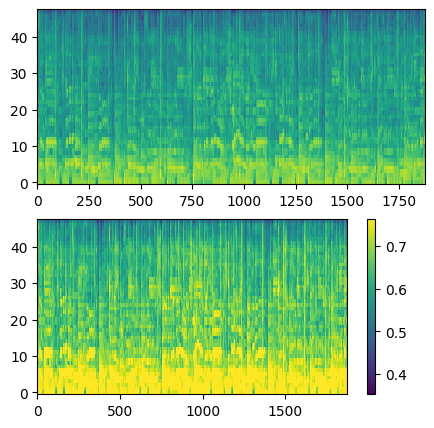

In [126]:
fig, ax = plt.subplots(2, figsize=(5,5))
im = ax[0].imshow(a[1], aspect='auto', origin='lower', interpolation='none')
im = ax[1].imshow(img_jt, aspect='auto', origin='lower', interpolation='none')
plt.colorbar(im)

In [127]:
img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
should_jt = jax.random.bernoulli(rng, p=0.8)
img = jnp.where(should_jt, img_jt, a[1])

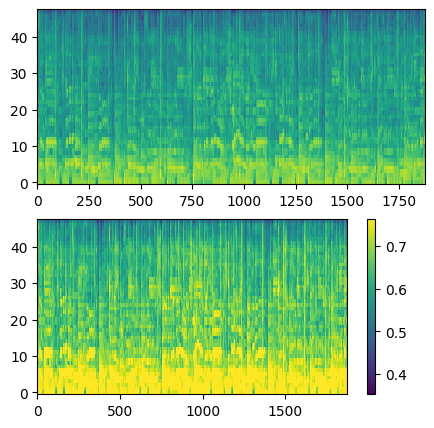

In [128]:
fig, ax = plt.subplots(2, figsize=(5,5))
im = ax[0].imshow(a[1], aspect='auto', origin='lower', interpolation='none')

im = ax[1].imshow(img, aspect='auto', origin='lower', interpolation='none')

plt.colorbar(im)

In [129]:
sigma = jax.random.uniform(rng, shape=(1,), minval=0.1, maxval=2.0)

img = dm_pix.gaussian_blur(img, sigma=sigma[0], kernel_size=9)


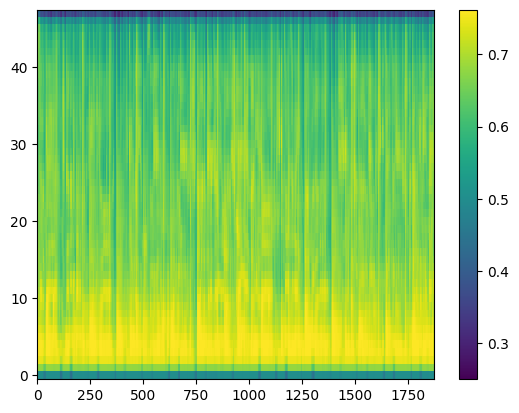

In [ ]:
plt.imshow(img, aspect='auto', origin='lower', interpolation='none')
plt.colorbar()

In [1]:
def augment_image(rng, img):
    rngs = jax.random.split(rng, 7)
    img_jt = img
    img_jt = img_jt * jax.random.uniform(rngs[1], shape=(1,), minval=0.5, maxval=1.5)  # Brightness
    img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
    img_jt = dm_pix.random_contrast(rngs[2], img_jt, lower=0.5, upper=1.5)
    img_jt = jax.lax.clamp(0.0, img_jt, 1.0)
    should_jt = jax.random.bernoulli(rngs[5], p=0.8)
    img = jnp.where(should_jt, img_jt, img)   
    # Gaussian blur
    sigma = jax.random.uniform(rngs[7], shape=(1,), minval=0.5, maxval=1.5)
    img = dm_pix.gaussian_blur(img, sigma=sigma[0], kernel_size=9)
    # Normalization
    img = jax.lax.clamp(0.0, img, 1.0)

    return img

In [2]:
rng, key = jax.random.split(key)
fig, ax = plt.subplots(4, figsize=(10,5))
im = ax[0].imshow(augment_image(rng, a[2]), aspect='auto', origin='lower', interpolation='none')
rng, key = jax.random.split(key)

im = ax[1].imshow(augment_image(rng, a[2]), aspect='auto', origin='lower', interpolation='none')
im = ax[2].imshow(augment_image(rng, a[20]), aspect='auto', origin='lower', interpolation='none')
rng, key = jax.random.split(key)

im = ax[3].imshow(augment_image(rng, a[20]), aspect='auto', origin='lower', interpolation='none')
plt.colorbar(im)

NameError: name 'jax' is not defined

In [278]:
parallel_augment = jax.jit(lambda rng, imgs: jax.vmap(augment_image)(jax.random.split(rng, imgs.shape[0]), imgs))

In [280]:
%%timeit
_ = parallel_augment(rng, a)

110 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [283]:
parallel_augment(rng, a).shape

(16, 48, 1876, 1)

In [299]:
def collate_batch(batch):
    x_train = [x for x, _ in batch]
    y_train = [y for _, y in batch]
    
    return np.array(x_train), np.array(y_train)



train_dataloader = DataLoader(data, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_batch)
a = next(iter(train_dataloader))[0]
a = jnp.expand_dims(a, axis=-1)
print(a.shape)

(64, 48, 1876, 1)


In [405]:
def contrastive_collate_batch(batch):
    x_train = [x for x, _ in batch]
    
    y_train = [y for _, y in batch]                  
    return np.stack(x_train + x_train, axis=0), np.array(y_train)

train_dataloader = DataLoader(data, batch_size=4, shuffle=True, num_workers=0, collate_fn=contrastive_collate_batch)

a, b = next(iter(train_dataloader))
a = jnp.expand_dims(a, axis=-1)


In [406]:
a.shape

(8, 48, 1876, 1)

In [407]:
a[0].shape

(48, 1876, 1)

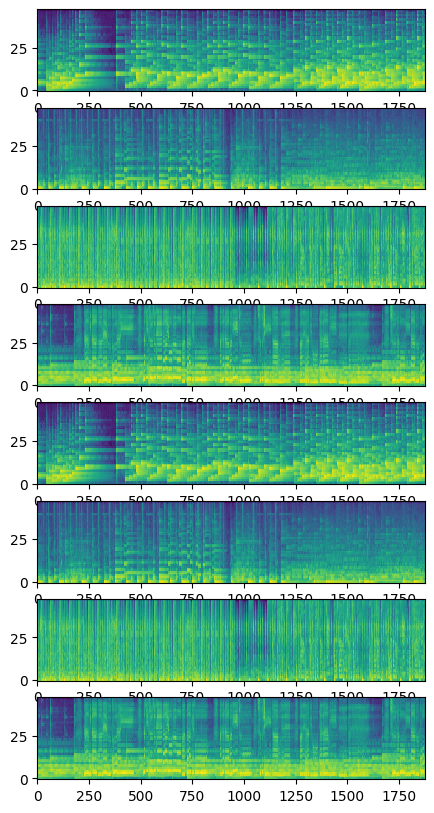

In [409]:
fig, ax = plt.subplots(8, figsize=(5,10))
for i in range(8):
    ax[i].imshow(a[i], aspect='auto', origin='lower', interpolation='none')




In [410]:
a = a/130 + 1

In [411]:
b = parallel_augment(rng, a)

In [412]:
b.shape

(8, 48, 1876, 1)

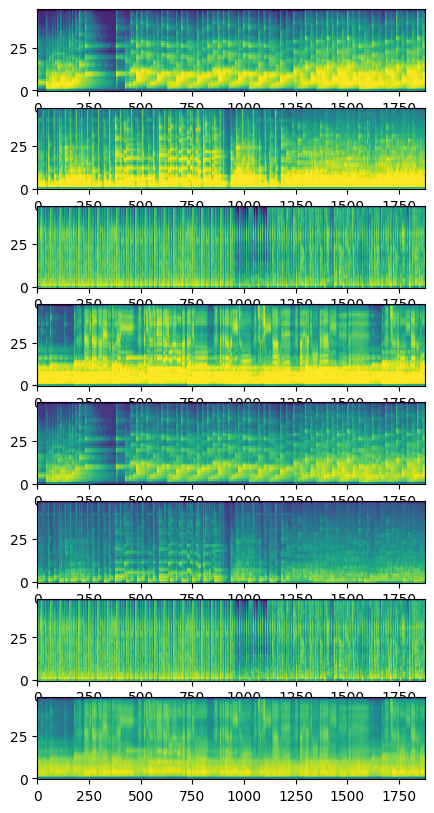

In [414]:
fig, ax = plt.subplots(8, figsize=(5,10))
for i in range(8):
    ax[i].imshow(b[i], aspect='auto', origin='lower', interpolation='none')


